# Import libraries

In [5]:
# Import libraries
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import importlib.util
import sys
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import BatchNormalization
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to the module search path
sys.path.append(parent_dir)

# Import functions from helpers module
from helpers import parse_variables, get_risk_level, map_to_color

In [6]:
dict = parse_variables('../geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

# Load populations

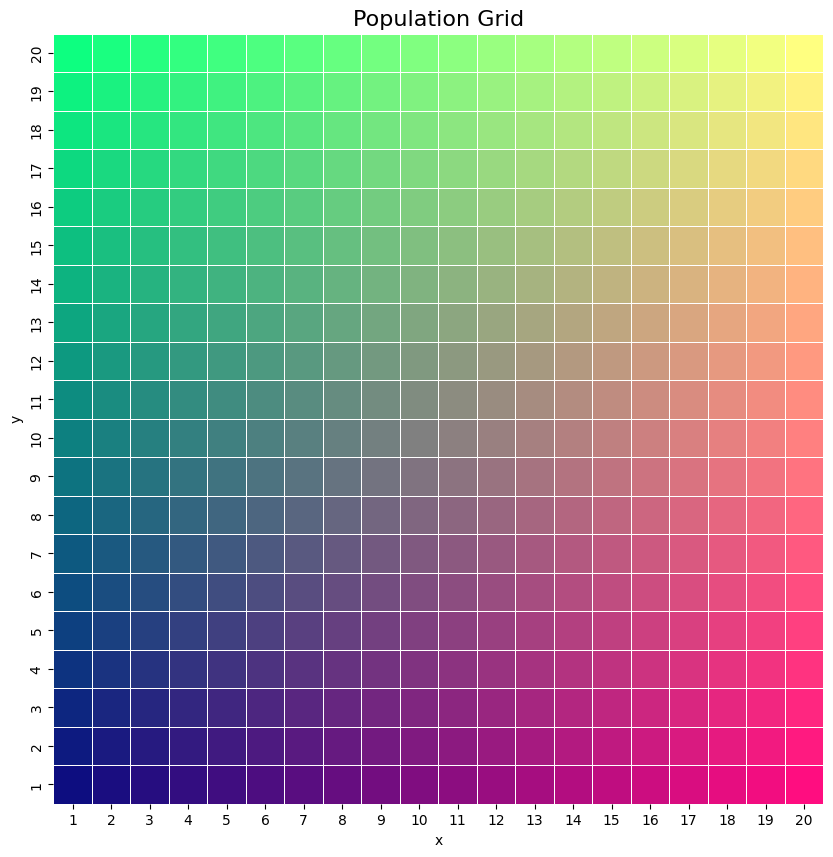

In [7]:
populations = pd.read_pickle(f"../data/phenotype/simulated_population_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
populations['population'] = populations['populations'].str.extract('(\d+)').astype(int)
populations["population_number"] = populations['population']/populations['population'].max()
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Load data

In [8]:
geno = pd.read_pickle(f"../data/genotype/simulated_complete_genotypes_AF_0_0.5_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")

In [9]:
AFs = pd.read_pickle(f"../data/genotype/simulated_complete_frequencies_AF_0_0.5_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")

In [10]:
AFs

,AFs
G1,0.335150
G2,0.040275
G3,0.041100
G4,0.363325
G5,0.005600
...,...
G496,0.169775
G497,0.026225
G498,0.093400
G499,0.419925


# Reduce to 2 PCs

In [11]:
# Standardize the data
scaler = StandardScaler()
scaled_geno = scaler.fit_transform(geno)
# Apply PCA to get the first two principal components
n_components = 25
pca = PCA(n_components=n_components)
pc_labels = [f"PC{i}" for i in range(1, n_components + 1)]

PC_geno = pca.fit_transform(scaled_geno)
scaled_PC = scaler.fit_transform(PC_geno)
PC_geno = pd.DataFrame(data=scaled_PC, columns=pc_labels)

In [12]:
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
PC_geno[to_have_collumns] = populations[to_have_collumns]

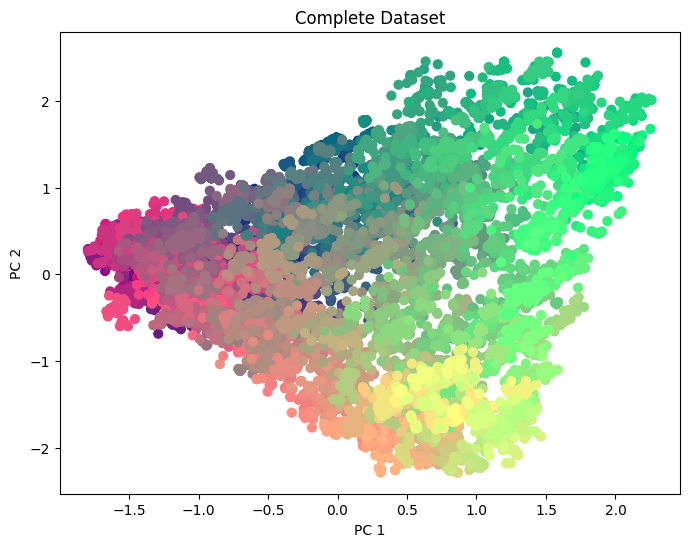

In [13]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = PC_geno['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, PC_geno) for x, y, z in zip(PC_geno['x'], PC_geno['y'], PC_geno['z'])]
plt.scatter(x=PC_geno['PC1'], y=PC_geno['PC2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

# Reconstruction from PCA

In [14]:
columns_to_drop  = ['populations','population_number', 'x', 'y','z','population']
PC_geno = PC_geno.drop(columns=columns_to_drop)

In [15]:
unique_values = geno.apply(pd.unique)

In [16]:
geno = geno - 1
geno

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G491,G492,G493,G494,G495,G496,G497,G498,G499,G500
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(PC_geno, geno, test_size=0.2, random_state=42)

# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Model Definition
activations = ['sigmoid']

for activation in activations:
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(geno.shape[1], activation='elu')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model with Early Stopping
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 1ms/step - loss: 0.0251 - mean_absolute_error: 0.0988


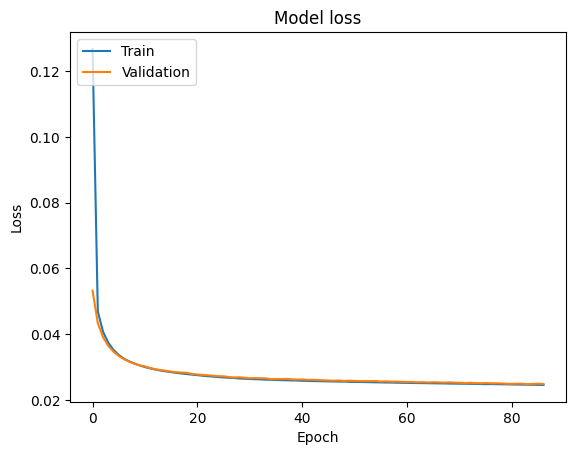

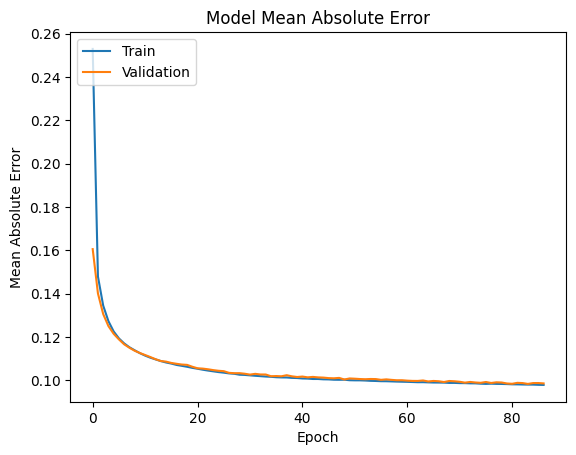

Test Loss: 0.025051303207874298
Test MAE: 0.09877649694681168


In [18]:
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy (if applicable)
    if 'mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'])
        plt.plot(history.history['val_mean_absolute_error'])
        plt.title('Model Mean Absolute Error')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    # Print test loss and accuracy
    print(f"Test Loss: {test_loss}")
    print(f"Test MAE: {test_acc}")

In [19]:
tensor_pc = tf.convert_to_tensor(PC_geno, dtype=tf.float32)

In [20]:
pd.DataFrame(data=model(tensor_pc), columns = geno.columns)

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G491,G492,G493,G494,G495,G496,G497,G498,G499,G500
0,0.004398,0.974689,0.768437,-0.078749,0.977597,0.953023,1.013359,1.054704,0.959665,1.093607,...,1.064342,0.930763,0.954876,0.077563,0.897360,0.924172,1.056037,0.932073,0.096720,0.974654
1,0.004398,0.974689,0.768437,-0.078749,0.977597,0.953023,1.013359,1.054704,0.959665,1.093607,...,1.064342,0.930763,0.954876,0.077563,0.897360,0.924172,1.056037,0.932073,0.096720,0.974654
2,0.004398,0.974689,0.768437,-0.078749,0.977597,0.953023,1.013359,1.054704,0.959665,1.093607,...,1.064342,0.930763,0.954876,0.077563,0.897360,0.924172,1.056037,0.932073,0.096720,0.974654
3,0.004398,0.974689,0.768437,-0.078749,0.977597,0.953023,1.013359,1.054704,0.959665,1.093607,...,1.064342,0.930763,0.954876,0.077563,0.897360,0.924172,1.056037,0.932073,0.096720,0.974654
4,0.004398,0.974689,0.768437,-0.078749,0.977597,0.953023,1.013359,1.054704,0.959665,1.093607,...,1.064342,0.930763,0.954876,0.077563,0.897360,0.924172,1.056037,0.932073,0.096720,0.974654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.000630,0.977693,0.936815,0.941885,1.001759,0.953509,-0.057982,-0.001169,1.001969,0.066559,...,0.940843,1.056743,0.708047,-0.070213,0.754395,1.021604,1.076164,1.103028,0.044986,1.014468
19996,1.015488,1.010660,0.914331,0.969103,0.987109,0.965129,-0.034374,-0.011612,0.943459,0.043860,...,0.943546,1.061438,0.687656,-0.069601,0.774809,0.991318,1.042712,1.123584,-0.111488,1.046888
19997,1.015488,1.010660,0.914331,0.969103,0.987109,0.965129,-0.034374,-0.011612,0.943459,0.043860,...,0.943546,1.061438,0.687656,-0.069601,0.774809,0.991318,1.042712,1.123584,-0.111488,1.046888
19998,1.015488,1.010660,0.914331,0.969103,0.987109,0.965129,-0.034374,-0.011612,0.943459,0.043860,...,0.943547,1.061438,0.687656,-0.069601,0.774809,0.991318,1.042712,1.123584,-0.111488,1.046888


In [21]:
probmaf = (pd.DataFrame(data=model(tensor_pc), columns = geno.columns)+1)/2

In [22]:
probmaf = 1-probmaf
probmaf

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G491,G492,G493,G494,G495,G496,G497,G498,G499,G500
0,0.497801,0.012655,0.115782,0.539375,0.011201,0.023489,-0.006680,-0.027352,0.020167,-0.046803,...,-0.032171,0.034618,0.022562,0.461218,0.051320,0.037914,-0.028019,0.033964,0.451640,0.012673
1,0.497801,0.012655,0.115782,0.539375,0.011201,0.023489,-0.006680,-0.027352,0.020167,-0.046803,...,-0.032171,0.034618,0.022562,0.461218,0.051320,0.037914,-0.028019,0.033964,0.451640,0.012673
2,0.497801,0.012655,0.115782,0.539375,0.011201,0.023489,-0.006680,-0.027352,0.020167,-0.046803,...,-0.032171,0.034618,0.022562,0.461218,0.051320,0.037914,-0.028019,0.033964,0.451640,0.012673
3,0.497801,0.012655,0.115782,0.539375,0.011201,0.023489,-0.006680,-0.027352,0.020167,-0.046803,...,-0.032171,0.034618,0.022562,0.461218,0.051320,0.037914,-0.028019,0.033964,0.451640,0.012673
4,0.497801,0.012655,0.115782,0.539375,0.011201,0.023489,-0.006680,-0.027352,0.020167,-0.046803,...,-0.032171,0.034618,0.022562,0.461218,0.051320,0.037914,-0.028019,0.033964,0.451640,0.012673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.000315,0.011153,0.031592,0.029058,-0.000880,0.023245,0.528991,0.500585,-0.000985,0.466721,...,0.029578,-0.028371,0.145977,0.535106,0.122802,-0.010802,-0.038082,-0.051514,0.477507,-0.007234
19996,-0.007744,-0.005330,0.042834,0.015449,0.006446,0.017435,0.517187,0.505806,0.028270,0.478070,...,0.028227,-0.030719,0.156172,0.534801,0.112596,0.004341,-0.021356,-0.061792,0.555744,-0.023444
19997,-0.007744,-0.005330,0.042834,0.015449,0.006446,0.017435,0.517187,0.505806,0.028270,0.478070,...,0.028227,-0.030719,0.156172,0.534801,0.112596,0.004341,-0.021356,-0.061792,0.555744,-0.023444
19998,-0.007744,-0.005330,0.042834,0.015449,0.006446,0.017435,0.517187,0.505806,0.028270,0.478070,...,0.028227,-0.030719,0.156172,0.534801,0.112596,0.004341,-0.021356,-0.061792,0.555744,-0.023444


In [23]:
estimated_AF = probmaf.mean(axis=0)

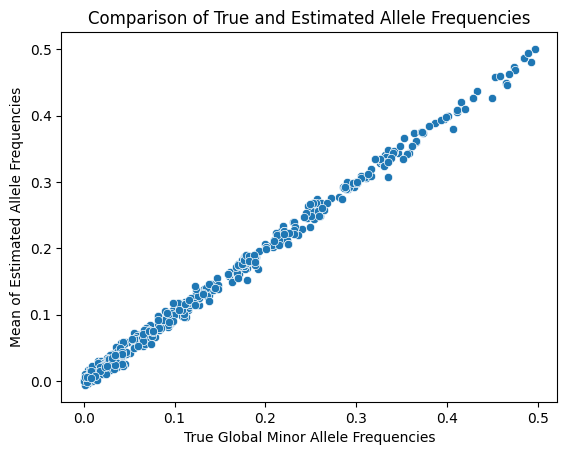

In [24]:
sns.scatterplot(x=list(AFs['AFs']), y=list(estimated_AF))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies')
plt.show()

# same but with an autoencoder

In [25]:
bottleneck_nr = 10
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
dim_columns

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10']

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)

# Regularization parameter
l2_regularizer = 0.001

# Original autoencoder model with L2 regularization
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Dense(bottleneck_nr, activation='linear', name='bottleneck', input_shape=(geno.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
    BatchNormalization(),
    tf.keras.layers.Activation('linear'),
    tf.keras.layers.Dense(geno.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))
])

# Compile the original model with L2 regularization
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mean_absolute_error'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the original model with Early Stopping
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Extract the bottleneck layer
bottleneck_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)

# Get bottleneck layer activations for train and test data
X_train_bottleneck = bottleneck_model.predict(X_train)
X_test_bottleneck = bottleneck_model.predict(X_test)

# Evaluate the original model on the test set
test_loss, test_acc = autoencoder.evaluate(X_test, y_test)


125/125 [==============================] - 0s 1ms/step - loss: 0.0785 - mean_absolute_error: 0.1763


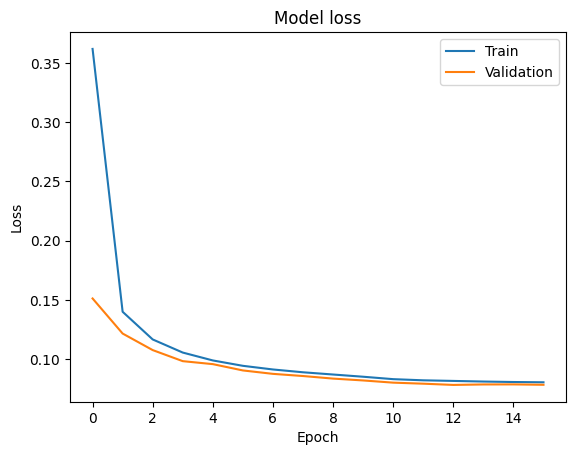

In [27]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
tensor_geno= tf.convert_to_tensor(geno, dtype=tf.float32)
probmaf = (pd.DataFrame(data=autoencoder(tensor_geno), columns = geno.columns)+1)/2
probmaf = 1-probmaf
probmaf.to_pickle(f"../data/estimated p values/estimated_AF_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
estimated_AF = probmaf.mean(axis=0)

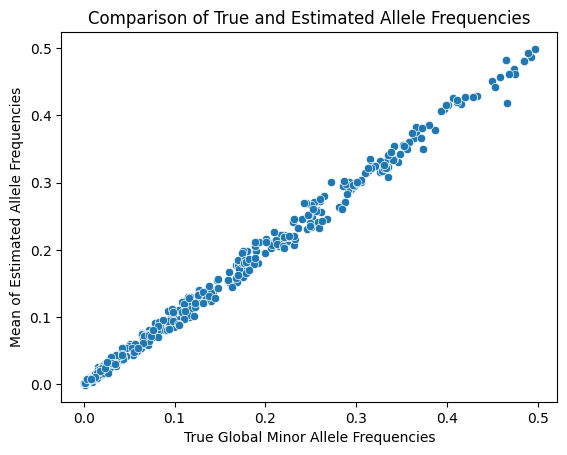

In [29]:
sns.scatterplot(x=list(AFs['AFs']), y=list(estimated_AF))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies')
plt.show()

In [30]:
# Obtain the bottleneck outputs
AE_bottle = bottleneck_model.predict(tensor_geno)
AE_bottle

625/625 [==============================] - 1s 941us/step


array([[-0.21024719, -0.54162884,  0.15332492, ..., -0.06929763,
         0.12072645, -0.16055298],
       [-0.21024719, -0.54162884,  0.15332492, ..., -0.06929763,
         0.12072645, -0.16055298],
       [-0.21024719, -0.54162884,  0.15332492, ..., -0.06929763,
         0.12072645, -0.16055298],
       ...,
       [-0.41300088,  0.05682581, -0.5138771 , ...,  0.1525641 ,
        -0.21757494,  0.5623871 ],
       [-0.41300082,  0.05682581, -0.51387715, ...,  0.15256411,
        -0.21757497,  0.562387  ],
       [-0.41300082,  0.05682581, -0.51387715, ...,  0.15256411,
        -0.21757497,  0.562387  ]], dtype=float32)

In [31]:
PC_geno

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
0,-0.626411,0.269009,1.357112,0.042289,0.922900,0.200955,-0.650921,1.217480,-0.047462,0.624981,...,1.058871,-0.602346,-0.318262,0.988979,-0.713074,-1.210672,1.539182,0.584183,0.022340,-0.725874
1,-0.626411,0.269009,1.357112,0.042289,0.922900,0.200955,-0.650921,1.217480,-0.047462,0.624981,...,1.058871,-0.602346,-0.318262,0.988979,-0.713074,-1.210672,1.539182,0.584183,0.022340,-0.725874
2,-0.626411,0.269009,1.357112,0.042289,0.922900,0.200955,-0.650921,1.217480,-0.047462,0.624981,...,1.058871,-0.602346,-0.318262,0.988979,-0.713074,-1.210672,1.539182,0.584183,0.022340,-0.725874
3,-0.626411,0.269009,1.357112,0.042289,0.922900,0.200955,-0.650921,1.217480,-0.047462,0.624981,...,1.058871,-0.602346,-0.318262,0.988979,-0.713074,-1.210672,1.539182,0.584183,0.022340,-0.725874
4,-0.626411,0.269009,1.357112,0.042289,0.922900,0.200955,-0.650921,1.217480,-0.047462,0.624981,...,1.058871,-0.602346,-0.318262,0.988979,-0.713074,-1.210672,1.539182,0.584183,0.022340,-0.725874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.442273,-1.355685,-0.547445,-0.182891,-1.086969,0.698124,-1.456643,-1.070027,1.780191,-1.132765,...,-0.495102,-0.039177,-0.180841,-1.052470,-0.188729,0.843162,0.897317,0.231761,-0.417184,-0.395632
19996,0.825037,-1.568757,-0.814346,-0.395227,-1.109057,0.790650,-0.587744,-0.721856,0.647144,-0.574868,...,-0.337032,-0.262905,-0.825697,-0.640039,-0.089057,0.749309,0.705007,0.204537,-0.670503,-0.206755
19997,0.825037,-1.568757,-0.814346,-0.395227,-1.109057,0.790650,-0.587744,-0.721856,0.647144,-0.574868,...,-0.337032,-0.262905,-0.825697,-0.640039,-0.089057,0.749309,0.705007,0.204537,-0.670503,-0.206755
19998,0.825037,-1.568757,-0.814346,-0.395227,-1.109057,0.790650,-0.587744,-0.721856,0.647144,-0.574868,...,-0.337032,-0.262905,-0.825697,-0.640039,-0.089057,0.749309,0.705007,0.204537,-0.670503,-0.206755


In [32]:
bottle = pd.DataFrame(AE_bottle, columns=dim_columns)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle[to_have_collumns] = populations[to_have_collumns]

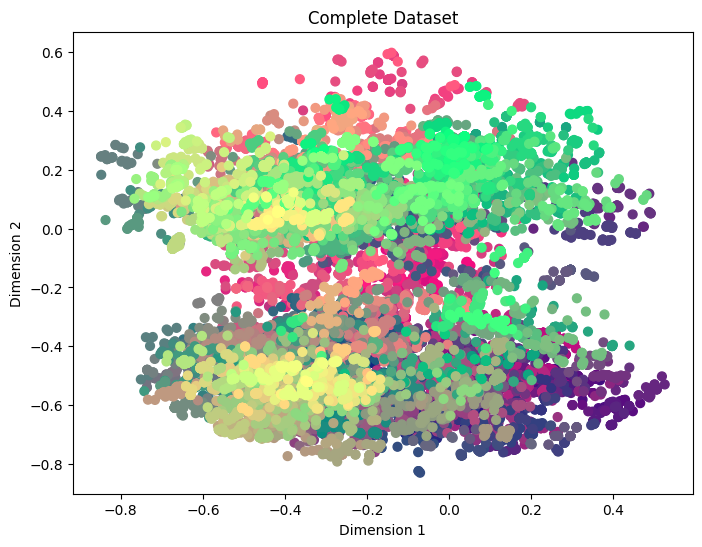

In [33]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle) for x, y, z in zip(bottle['x'], bottle['y'], bottle['z'])]
plt.scatter(x=bottle['dim1'], y=bottle['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

In [34]:
nr = 3
probmaf[f"G{nr}"]

0        0.074600
1        0.074600
2        0.074600
3        0.074600
4        0.074600
           ...   
19995    0.003293
19996   -0.013428
19997   -0.013428
19998   -0.013428
19999   -0.013428
Name: G3, Length: 20000, dtype: float32

In [35]:
bottle[f"AF G{nr}"] = list(probmaf[f"G{nr}"])

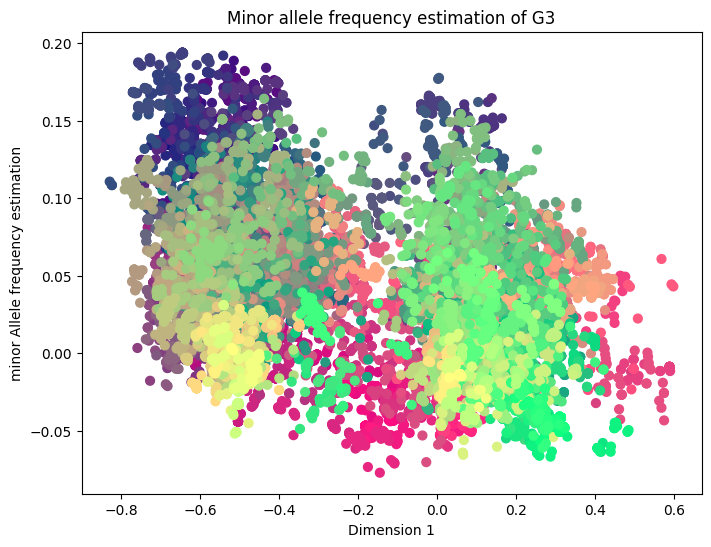

In [36]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle) for x, y, z in zip(bottle['x'], bottle['y'], bottle['z'])]
plt.scatter(x=bottle['dim2'], y=bottle[f"AF G{nr}"], c=colors, s=40)

plt.title(f"Minor allele frequency estimation of G{nr}")  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('minor Allele frequency estimation')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

In [37]:
os.listdir("../data/estimated p values")

['estimated_AF_G20_L100_c50_k10_M0.2.pkl',
 'estimated_AF_G20_L50_c50_k20_M0.1.pkl',
 'estimated_af_deep_G20_L50_c50_k20_M0.1.pkl',
 'estimated_af_deep_G20_L100_c50_k10_M0.2.pkl',
 'estimated_af_deep_G20_L100_c10_k20_M0.2.pkl',
 'estimated_AF_G20_L100_c10_k20_M0.2.pkl',
 '.ipynb_checkpoints',
 'estimated_genotype_G20_L100_c50_k10_M0.2.pkl']